In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('data/csv/Athabasca_MultiProduct_with_AWS.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset Shape: (1298, 40)

Columns: ['pixel_id', 'date', 'qa_mode', 'albedo_MOD09GA', 'albedo_MYD09GA', 'albedo_mcd43a3', 'albedo_mod10a1', 'albedo_myd10a1', 'albedo_AWS', 'ndsi_MOD09GA', 'ndsi_MYD09GA', 'ndsi_mcd43a3', 'ndsi_mod10a1', 'ndsi_myd10a1', 'glacier_fraction_MOD09GA', 'glacier_fraction_MYD09GA', 'glacier_fraction_mcd43a3', 'glacier_fraction_mod10a1', 'glacier_fraction_myd10a1', 'solar_zenith_MOD09GA', 'solar_zenith_MYD09GA', 'solar_zenith_mcd43a3', 'solar_zenith_mod10a1', 'solar_zenith_myd10a1', 'elevation', 'slope', 'aspect', 'longitude', 'latitude', 'tile_h', 'tile_v', 'pixel_row', 'pixel_col', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07']

First few rows:


,pixel_id,date,qa_mode,albedo_MOD09GA,albedo_MYD09GA,albedo_mcd43a3,albedo_mod10a1,albedo_myd10a1,albedo_AWS,ndsi_MOD09GA,...,tile_v,pixel_row,pixel_col,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,sur_refl_b07
0,9073025950,2014-06-01,qa_0_and_1,NaN,NaN,0.482,NaN,NaN,NaN,NaN,...,5219,9073,25950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9073025950,2014-06-01,renoriginal,0.334372,NaN,NaN,NaN,NaN,NaN,0.77677,...,5219,9073,25950,0.3995,0.3269,0.4097,0.4115,0.0993,0.0517,0.0414
2,9073025950,2014-06-01,standard_qa,NaN,NaN,NaN,0.29,NaN,NaN,NaN,...,5219,9073,25950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9073025950,2014-06-02,qa_0_and_1,NaN,NaN,0.486,NaN,NaN,NaN,NaN,...,5219,9073,25950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9073025950,2014-06-03,qa_0_and_1,NaN,NaN,0.491,NaN,NaN,NaN,NaN,...,5219,9073,25950,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Create merged/fused albedo from MOD09GA and MYD09GA
def create_merged_albedo(df):
    """Create merged albedo preferring MOD09GA, falling back to MYD09GA"""
    merged = df['albedo_MOD09GA'].copy()
    # Fill missing MOD09GA values with MYD09GA
    merged = merged.fillna(df['albedo_MYD09GA'])
    return merged

def create_averaged_albedo(df):
    """Create averaged albedo from both MOD09GA and MYD09GA when both available"""
    both_available = df['albedo_MOD09GA'].notna() & df['albedo_MYD09GA'].notna()
    averaged = df['albedo_MOD09GA'].copy()
    
    # Average when both are available
    averaged.loc[both_available] = (df.loc[both_available, 'albedo_MOD09GA'] + 
                                   df.loc[both_available, 'albedo_MYD09GA']) / 2
    
    # Fill missing values
    averaged = averaged.fillna(df['albedo_MYD09GA'])
    
    return averaged

# Create fusion products
df['merged_albedo_mod09ga'] = create_merged_albedo(df)
df['averaged_albedo_fusion'] = create_averaged_albedo(df)

# Filter data with AWS measurements
aws_data = df[df['albedo_AWS'].notna()].copy()

print(f"Dataset with AWS measurements: {len(aws_data)} records")
print(f"Available merged MOD09GA albedo: {aws_data['merged_albedo_mod09ga'].notna().sum()} records")
print(f"Available averaged fusion albedo: {aws_data['averaged_albedo_fusion'].notna().sum()} records")
print(f"Individual MOD09GA: {aws_data['albedo_MOD09GA'].notna().sum()} records")
print(f"Individual MYD09GA: {aws_data['albedo_MYD09GA'].notna().sum()} records")

Dataset with AWS measurements: 926 records
Available merged MOD09GA albedo: 356 records
Available averaged fusion albedo: 356 records
Individual MOD09GA: 298 records
Individual MYD09GA: 131 records


In [12]:
# Statistical comparison function
def calculate_stats(predicted, observed, label):
    """Calculate comparison statistics"""
    valid_mask = predicted.notna() & observed.notna()
    pred_valid = predicted[valid_mask]
    obs_valid = observed[valid_mask]
    
    if len(pred_valid) == 0:
        return None
    
    mae = np.mean(np.abs(pred_valid - obs_valid))
    rmse = np.sqrt(np.mean((pred_valid - obs_valid)**2))
    bias = np.mean(pred_valid - obs_valid)
    corr = np.corrcoef(pred_valid, obs_valid)[0,1]
    r2 = corr**2
    
    return {
        'Product': label,
        'N': len(pred_valid),
        'MAE': mae,
        'RMSE': rmse,
        'Bias': bias,
        'R²': r2,
        'Correlation': corr
    }

# Compare all products against AWS
comparison_products = [
    ('merged_albedo_mod09ga', 'Merged MOD09GA'),
    ('averaged_albedo_fusion', 'Averaged Fusion'),
    ('albedo_MOD09GA', 'MOD09GA'),
    ('albedo_MYD09GA', 'MYD09GA')
]

stats_results = []
for col, label in comparison_products:
    stats = calculate_stats(aws_data[col], aws_data['albedo_AWS'], label)
    if stats:
        stats_results.append(stats)

# Create comparison table
stats_df = pd.DataFrame(stats_results)
stats_df = stats_df.round(4)
print("=== ALBEDO COMPARISON STATISTICS ===")
print(stats_df.to_string(index=False))

# Best performing product
best_mae = stats_df.loc[stats_df['MAE'].idxmin()]
best_r2 = stats_df.loc[stats_df['R²'].idxmax()]
print(f"\nBest MAE: {best_mae['Product']} (MAE = {best_mae['MAE']:.4f})")
print(f"Best R²: {best_r2['Product']} (R² = {best_r2['R²']:.4f})")

=== ALBEDO COMPARISON STATISTICS ===
        Product   N    MAE   RMSE    Bias     R²  Correlation
 Merged MOD09GA 356 0.0840 0.1300 -0.0369 0.2749       0.5243
Averaged Fusion 356 0.0824 0.1291 -0.0351 0.2703       0.5199
        MOD09GA 298 0.0850 0.1329 -0.0375 0.2920       0.5404
        MYD09GA 131 0.0697 0.1044 -0.0363 0.2262       0.4756

Best MAE: MYD09GA (MAE = 0.0697)
Best R²: MOD09GA (R² = 0.2920)


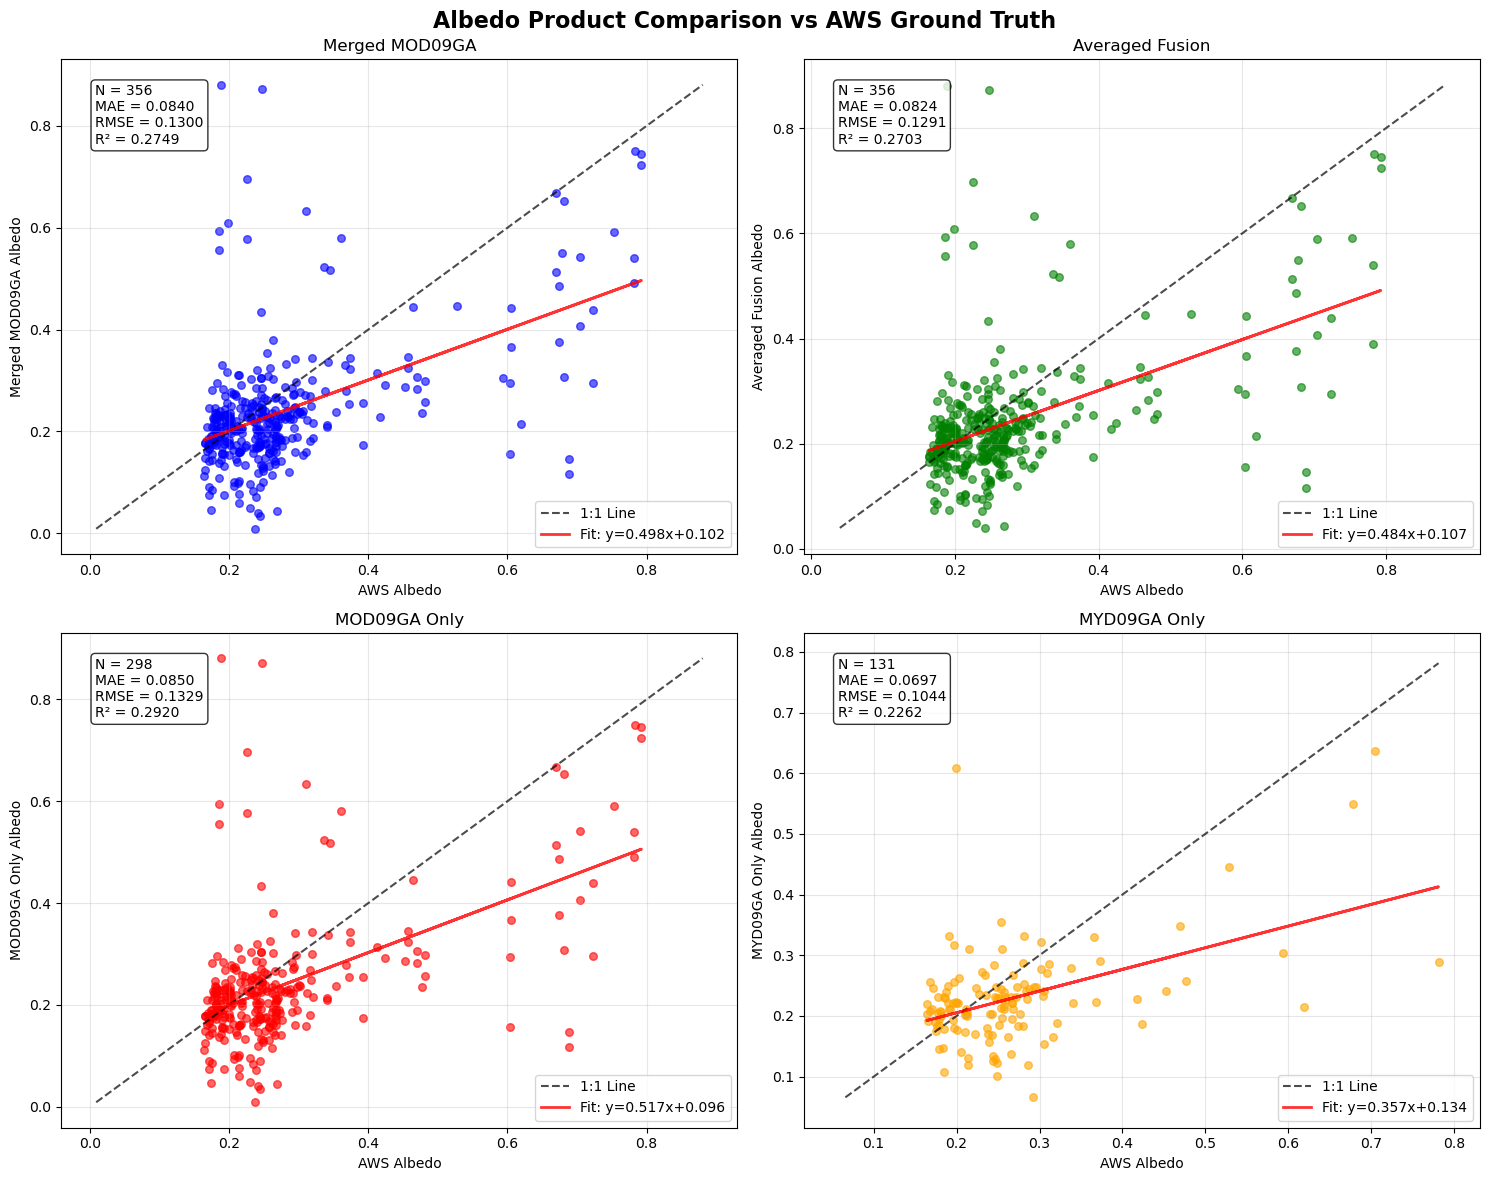

In [13]:
# Create comprehensive scatter plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Albedo Product Comparison vs AWS Ground Truth', fontsize=16, fontweight='bold')

products = [
    ('merged_albedo_mod09ga', 'Merged MOD09GA', 'blue'),
    ('averaged_albedo_fusion', 'Averaged Fusion', 'green'),
    ('albedo_MOD09GA', 'MOD09GA Only', 'red'),
    ('albedo_MYD09GA', 'MYD09GA Only', 'orange')
]

for idx, (col, title, color) in enumerate(products):
    ax = axes[idx//2, idx%2]
    
    # Filter valid data
    valid_data = aws_data[[col, 'albedo_AWS']].dropna()
    
    if len(valid_data) > 0:
        x = valid_data['albedo_AWS']
        y = valid_data[col]
        
        # Scatter plot
        ax.scatter(x, y, alpha=0.6, color=color, s=30)
        
        # 1:1 line
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7, label='1:1 Line')
        
        # Fit line
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax.plot(x, p(x), color='red', linewidth=2, alpha=0.8, label=f'Fit: y={z[0]:.3f}x+{z[1]:.3f}')
        
        # Statistics
        stats = calculate_stats(valid_data[col], valid_data['albedo_AWS'], title)
        ax.text(0.05, 0.95, f"N = {stats['N']}\nMAE = {stats['MAE']:.4f}\nRMSE = {stats['RMSE']:.4f}\nR² = {stats['R²']:.4f}", 
                transform=ax.transAxes, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax.set_xlabel('AWS Albedo')
        ax.set_ylabel(f'{title} Albedo')
        ax.set_title(f'{title}')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Set equal aspect ratio
        ax.set_xlim(min_val-0.05, max_val+0.05)
        ax.set_ylim(min_val-0.05, max_val+0.05)

plt.tight_layout()
plt.show()

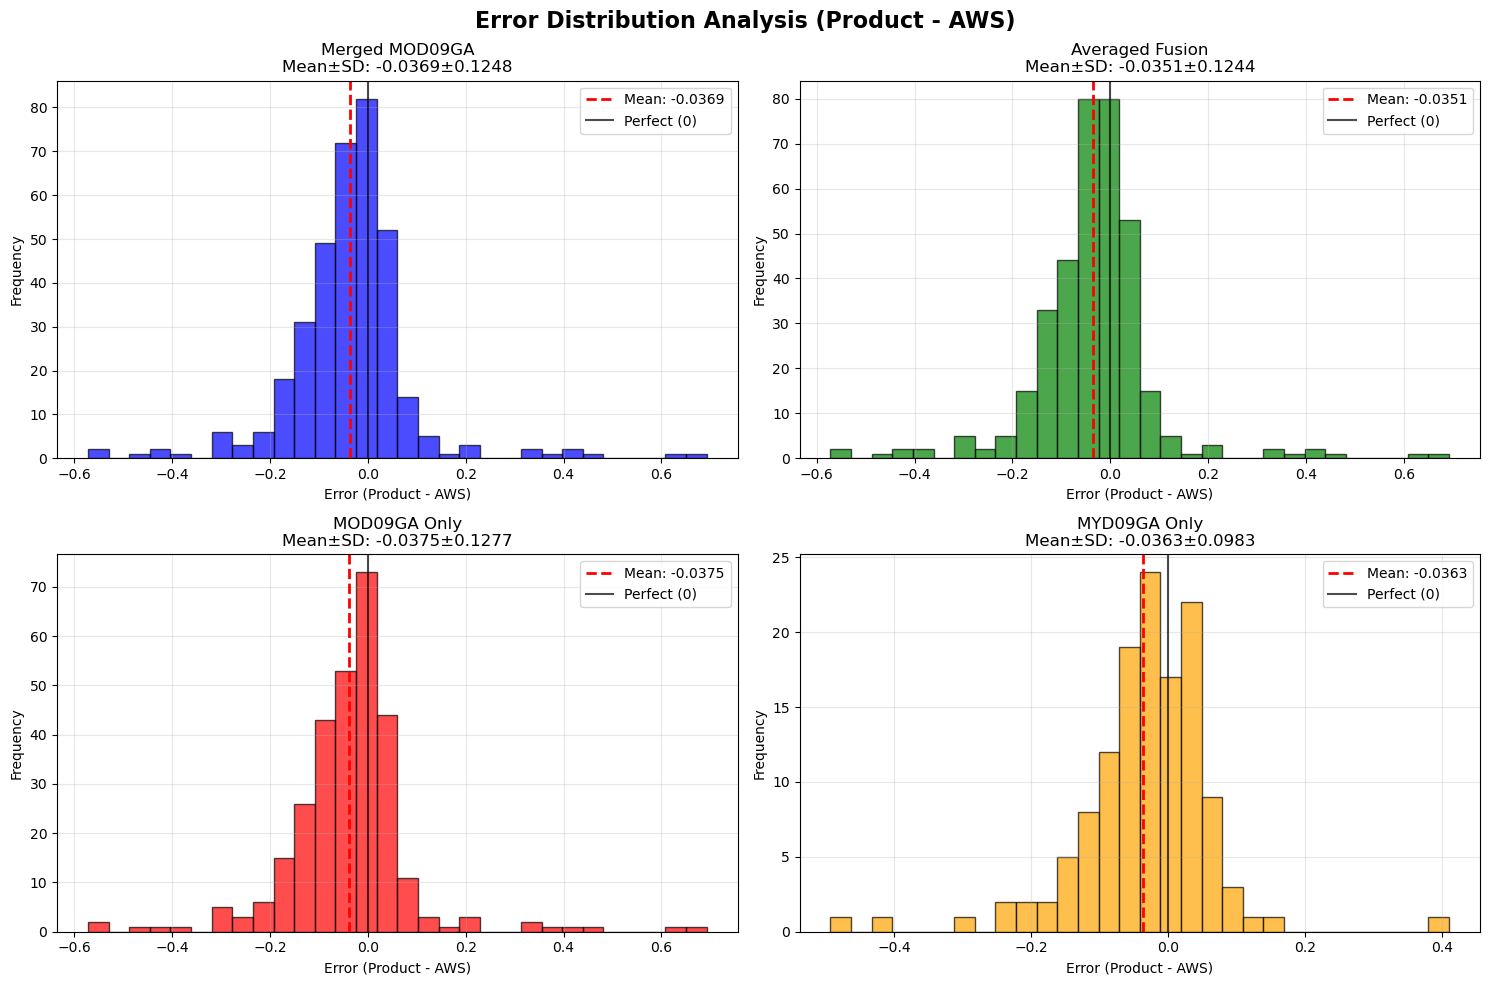

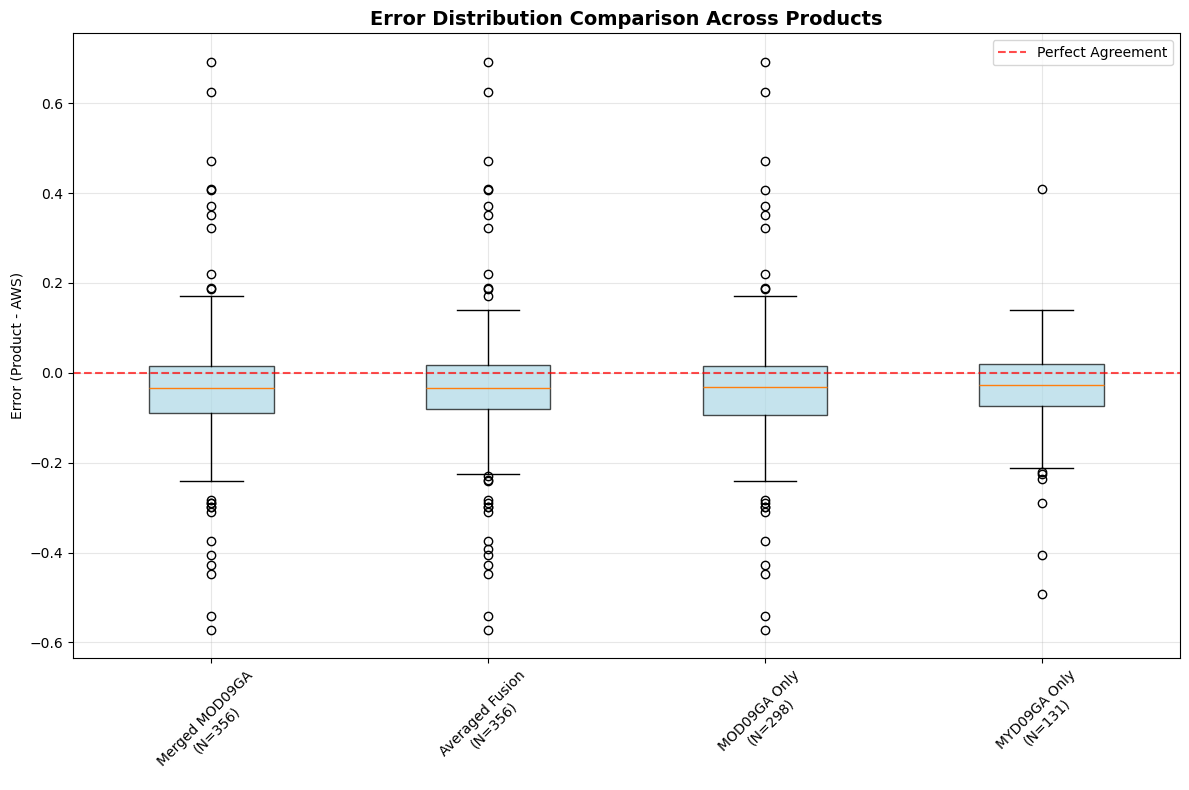

In [14]:
# Error distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Error Distribution Analysis (Product - AWS)', fontsize=16, fontweight='bold')

for idx, (col, title, color) in enumerate(products):
    ax = axes[idx//2, idx%2]
    
    # Calculate errors
    valid_data = aws_data[[col, 'albedo_AWS']].dropna()
    if len(valid_data) > 0:
        errors = valid_data[col] - valid_data['albedo_AWS']
        
        # Histogram
        ax.hist(errors, bins=30, alpha=0.7, color=color, edgecolor='black')
        
        # Statistics
        mean_error = errors.mean()
        std_error = errors.std()
        ax.axvline(mean_error, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_error:.4f}')
        ax.axvline(0, color='black', linestyle='-', alpha=0.7, label='Perfect (0)')
        
        ax.set_xlabel('Error (Product - AWS)')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{title}\nMean±SD: {mean_error:.4f}±{std_error:.4f}')
        ax.grid(True, alpha=0.3)
        ax.legend()

plt.tight_layout()
plt.show()

# Box plot comparison
plt.figure(figsize=(12, 8))
error_data = []
labels = []

for col, title, color in products:
    valid_data = aws_data[[col, 'albedo_AWS']].dropna()
    if len(valid_data) > 0:
        errors = valid_data[col] - valid_data['albedo_AWS']
        error_data.append(errors)
        labels.append(f'{title}\n(N={len(errors)})')

plt.boxplot(error_data, labels=labels, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', alpha=0.7))
plt.axhline(0, color='red', linestyle='--', alpha=0.7, label='Perfect Agreement')
plt.ylabel('Error (Product - AWS)')
plt.title('Error Distribution Comparison Across Products', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()